In [1]:
from glob import glob
import os

import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
import sklearn.metrics as sk_metrics

from decorata import data as D
from decorata import augmentations as DA
import albumentations as A

import seaborn as sns
import matplotlib.pyplot as plt

import json

In [2]:
dataset_path = ''
model_path = ''
model_name = ''
aug_dataset_path = ''
if not os.path.isdir(aug_dataset_path):
    os.mkdir(aug_dataset_path)

In [3]:
images = glob(os.path.join(dataset_path, '*', '*.jpg'))
labels = list(map(lambda x: x.split('/')[-2],images))

_, indexes = train_test_split(range(len(labels)), test_size=0.1, random_state=42, stratify=labels)
images = [images[i] for i in indexes]
labels = [labels[i] for i in indexes]
classes = sorted(list(set(labels)))

In [4]:
@D.base_inheritance
class ConvertColor:
    def __init__(self, dataset):
        self.__dict__ = dataset.__dict__.copy()
        self.dataset = dataset
    
    def __getitem__(self, index):
        sample = self.dataset[index]
        sample['image'] = cv2.cvtColor(sample['image'], cv2.COLOR_BGR2RGB)
        return sample

In [5]:
# augmentation = A.Compose([
#     A.RandomRotate90(p=0.5),
#     A.Flip(p=0.5),
#     A.ElasticTransform(p=0.5, alpha=1, sigma=20, alpha_affine=10, border_mode=1),
#     A.Blur(p=0.5, blur_limit=(3, 7)),
#     A.Downscale(p=0.5, scale_min=0.75, scale_max=0.99),
#     A.RGBShift(p=0.5),
#     A.ISONoise(p=0.5),
#     A.RandomBrightness(p=0.5),
#     A.RandomBrightnessContrast(p=0.5),
#     DA.KelvinWB(),
# ])

In [6]:
augmentation = A.Compose([
    A.RandomRotate90(p=1),

    A.OneOf([
        A.HorizontalFlip(p=0.7),
        A.VerticalFlip(p=0.7),
    ], p=0.7),

    A.OneOf([
        A.RandomContrast(p=0.7, limit=(-0.5, 0.3)),
        A.RandomBrightness(p=0.7, limit=(-0.2, 0.3)),
        DA.KelvinWB(p=0.5),
    ], p=0.7),
])

In [7]:
dataset = D.TFBaseDataset(images, labels, classes)
dataset = D.LoadImages(dataset)
dataset = D.ResizeImages(dataset, image_size=(224, 224))
dataset = ConvertColor(dataset)
dataset = D.OneHotLabels(dataset)
dataset = D.Augmentations(dataset, augmentation)
dataset = D.TFDataGenerator(dataset)

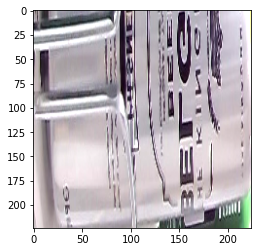

In [8]:
plt.imshow(dataset[0][0][0,:,:,:].astype(np.uint8))

In [9]:
model = tf.keras.models.load_model(os.path.join(model_path, model_name))
predictions = model.predict(dataset)
# model.summary()

In [10]:
def get_unstable_labels(labels, predictions, classes, criteria=0.95):
    '''
    labels: dataset에 있는 모든 label 목록
    predictions: inference 결과 (one hot encoding)
    classes: label class 목록. label을 one hot encoding 하기위해 필요
    criteria: 불안정한 class 검출을 위한 accuracy 기준. criteria 이하의 accuracy는 불안정한 class.
    '''
    labels_enc = list(map(classes.index, labels))
    pred_enc = np.argmax(predictions, axis=1)
    confusion = sk_metrics.confusion_matrix(labels_enc, pred_enc)
    confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
    unstable_labels = {}
    for i in range(len(classes)):
        impacts = {}
        if confusion_normalized[i, i] <= criteria:
            for j in range(len(classes)):
                if i != j:
                    impacts[classes[j]] = confusion_normalized[i, j]
            temp = sorted(impacts.items(), key=lambda x: -x[1])
            impacts = {}
            for k, v in temp[:min(5, len(classes)-1)]:
                impacts[k] = v
            unstable_labels[classes[i]] = (confusion_normalized[i, i], impacts)
    temp = sorted(unstable_labels.items(), key=lambda x: x[1][0])
    unstable_labels = {}
    for k, v in temp:
        unstable_labels[k] = v
    return unstable_labels

with open('unstable_labels.json', 'w') as outjson:
    json.dump(get_unstable_labels(labels, predictions, classes), outjson, indent=4)

In [14]:
def compute_f1_score(labels, predictions):
    """Compute confusion matrix and normalize."""
    labels_enc = list(map(classes.index, labels))
    pred_enc = np.argmax(predictions, axis=1)
    confusion = sk_metrics.confusion_matrix(labels_enc, pred_enc)

    # compute precision and recall
    accuracy = []
    precision = []
    recall = []
    f1 = []
    total = confusion.sum()
    diag_sum = 0
    for i in range(confusion.shape[0]):
        tp = confusion[i, i]
        diag_sum += tp
        pred = confusion[:, i].sum()
        act = confusion[i, :].sum()
        accuracy.append((total - (pred + act) + 2 * tp) / total)
        precision.append(tp / pred)
        recall.append(tp / act)
        f1.append(2 * tp / (pred + act))
    table = pd.DataFrame({'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1}, index=classes)
    total_precision = np.mean(np.nan_to_num(precision))
    total_recall = np.mean(np.nan_to_num(recall))
    total_f1 = 2 * total_precision * total_recall / (total_precision + total_recall)
    table = table.append(pd.DataFrame({'accuracy': diag_sum / total, 'precision': total_precision, 'recall': total_recall, 'f1_score': total_f1}, index=['total']))
    table.to_csv('scores.csv')
    return table

compute_f1_score(labels, predictions)

,accuracy,precision,recall,f1_score
belgium_export_500,1.000000,1.000000,1.000000,1.000000
belgium_pilsner_500,0.999639,0.994350,0.994350,0.994350
belgium_radler_500,1.000000,1.000000,1.000000,1.000000
belgium_weizen_500,1.000000,1.000000,1.000000,1.000000
big_wave_golden_ale_473,1.000000,1.000000,1.000000,1.000000
blanc1664_500,1.000000,1.000000,1.000000,1.000000
budweiser_500,1.000000,1.000000,1.000000,1.000000
carlsberg_500,1.000000,1.000000,1.000000,1.000000
cass_fresh_500,1.000000,1.000000,1.000000,1.000000
cass_light_500,1.000000,1.000000,1.000000,1.000000


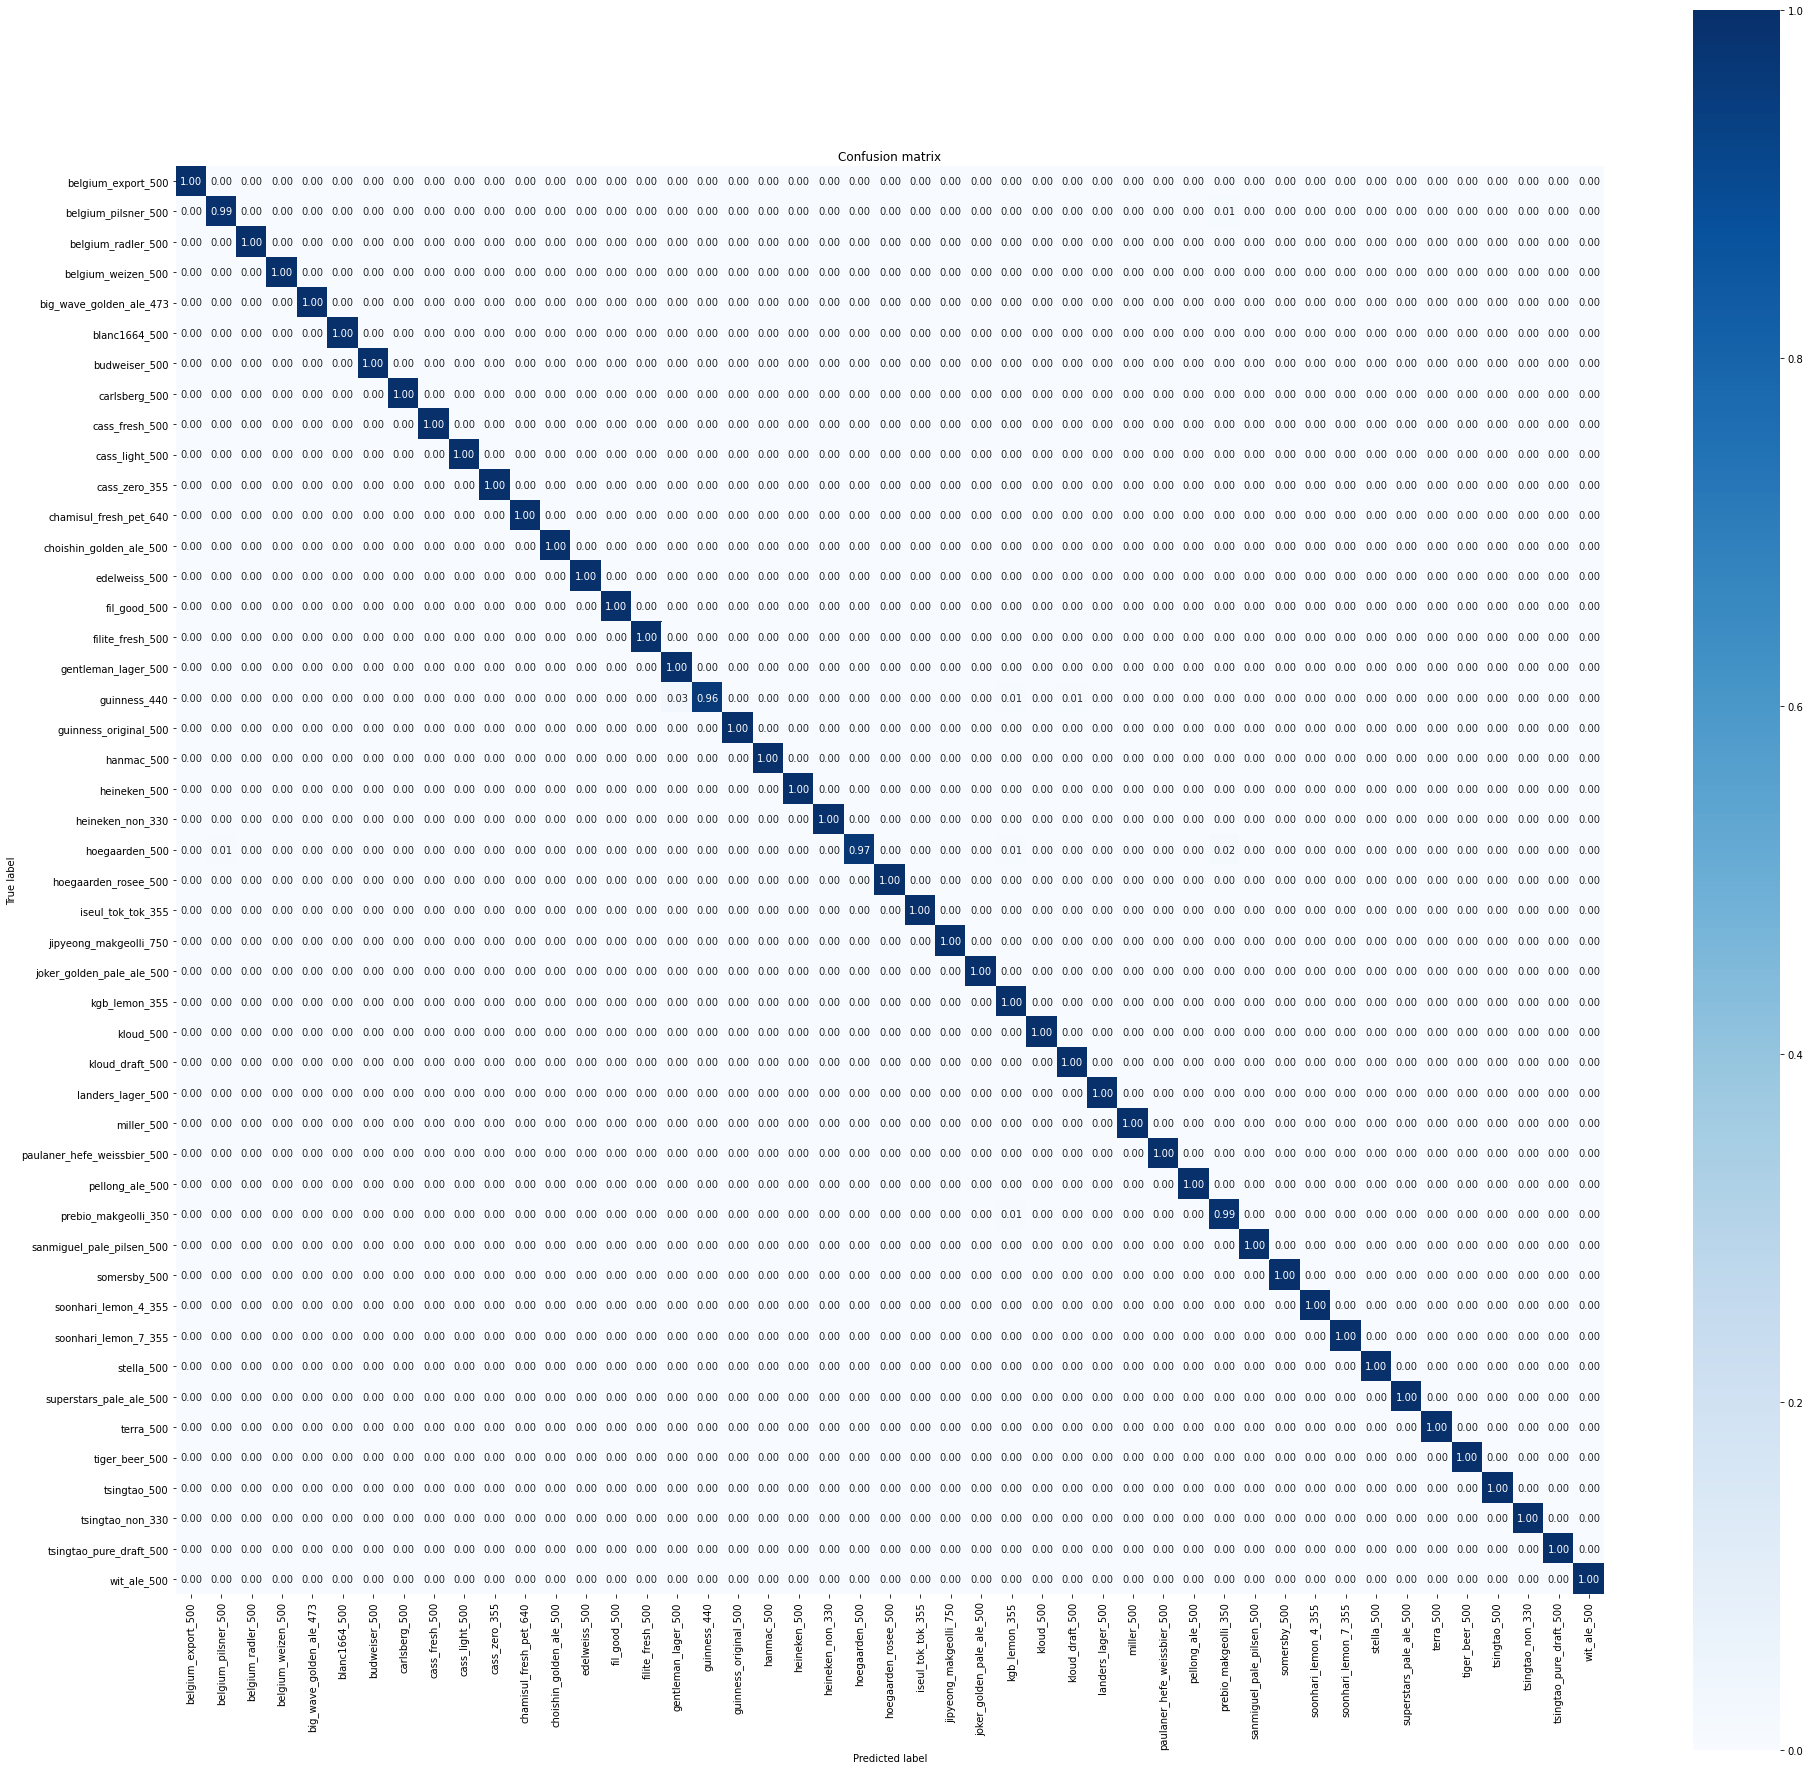

In [12]:
def show_confusion_matrix(labels, predictions):
    """Compute confusion matrix and normalize."""
    labels_enc = list(map(classes.index, labels))
    pred_enc = np.argmax(predictions, axis=1)
    confusion = sk_metrics.confusion_matrix(labels_enc, pred_enc)
    confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
    axis_labels = classes
    fig, ax = plt.subplots(figsize=(32, 32))
    ax = sns.heatmap(
        confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
        cmap='Blues', annot=True, fmt='.2f', square=True, ax=ax)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.savefig('confusion_matrix.png')

show_confusion_matrix(labels, predictions)